# Assignment 2: DenseNet with CIFAR10 Dataset by TensorFlow

In this assignment, you are required to implement DenseNet to classify images from the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) by using TensorFlow with Keras. DenseNet is very well-known and therefore it has been implemented and pre-trained by Keras. You are also required to load and test the pre-trained models, and compare them with your models.

First of all, read the DenseNet paper. DenseNet was originally proposed in 2016 by Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger in the following paper:
https://arxiv.org/abs/1608.06993

The process will be broken down into the following steps:
>1. Answer a short question about DenseNet. (10 marks)
2. Load and visualize the data.
3. Implement your models. (30 marks)
4. Train and evaluate your models. (25 marks)
5. Load the pre-trained models from Keras and evaluate them. (15 marks)
6. Analysis your results. (20 marks)

---
## 1. Answer a short question (20 marks)

Now that you know what DenseNet is all about, let's compare it to VGG.
Both VGG and DenseNet papers describe several variations of their models that differ by their depth.
For example, VGG16 and VGG19, DenseNet-121 and DenseNet-169 are four examples from these papers.

Aside from difference in network depth, how is the architecture of DenseNet different from that of VGG? Please enter your answer in the next cell (approximately 100-200 words, both English and Chinese are acceptable).

VGG网络是基于AlexNet的改进，主要思想是用多个小卷积核来代替一个大卷积核，使网络结构变得
复杂，学到更多信息的同时参数变得更少，网络变得更有效率。DenseNet主要是基于ResNet的改进，通过对特征图的重用，达到更浅的网络、更少的参数、更好的性能。DenseNet在设计网络的时候，也借鉴了VGG的结构，卷积层主要使用的是3×3的小卷积核。

---
## 2. Load and visualize the data.

The data is directly loaded into memory.

In [12]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

num_classes = 10

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
print(y_train[0])
# convert class vectors to binary class matrices.
#独热编码，将6转换成[0,0,0,0,0,0,1,0,0,0]
# y_train = to_categorical(y_train, num_classes)
# print('y_train shape:', y_train.shape)
# print(y_train[0])
from tensorflow.keras.datasets import cifar10from tensorflow.keras.datasets import cifar10# y_test = to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
[6]


In [20]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape((50000, 32, 32, 3)).astype('float32') / 255
x_test = x_test.reshape((10000, 32, 32, 3)).astype('float32') / 255


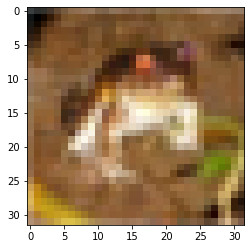

In [5]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

---
## 3. Implement your models (30 marks)

In this task, you are required to implement DenseNet-121 and DenseNet-169 as depicted in the original paper.

In [22]:
# implement the code of your DenseNet-121 model here.
#https://keras.io/zh/layers/convolutional/
import tensorflow as tf
from tensorflow.keras import layers

#https://keras.io/zh/layers/writing-your-own-keras-layers/  Keras2.0needed
#2.2.4-tf Satisfied

# 瓶颈层，相当于每一个稠密块中若干个相同的H函数
class BottleNeck(layers.Layer):
    # growth_rate对应的是论文中的增长率k，指经过一个BottleNet输出的特征图的通道数；drop_rate指失活率。
    def __init__(self, growth_rate, drop_rate):
        super(BottleNeck, self).__init__()
        self.bn1 = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=4 * growth_rate,  # 使用1*1卷积核将通道数降维到4*k
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding="same")
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv2D(filters=growth_rate,  # 使用3*3卷积核，使得输出维度（通道数）为k
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.dropout = layers.Dropout(rate=drop_rate)
        # 将网络层存入一个列表中
        self.listLayers = [self.bn1,
                           self.relu,
                           self.conv1,
                           self.bn2,
                           self.relu,
                           self.conv2,
                           self.dropout]

    def call(self, x):
        y = x
        for layer in self.listLayers.layers:
            y = layer(y)
        # 每经过一个BottleNet，将输入和输出按通道连结。作用是：将前l层的输入连结起来，作为下一个BottleNet的输入。
        y = layers.concatenate([x, y], axis=-1)
        return y

# 稠密块，由若干个相同的瓶颈层构成
class DenseBlock(layers.Layer):
    # num_layers表示该稠密块存在BottleNet的个数，也就是一个稠密块的层数L
    def __init__(self, num_layers, growth_rate, drop_rate=0.5):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.growth_rate = growth_rate
        self.drop_rate = drop_rate
        self.listLayers = []
        # 一个DenseBlock由多个相同的BottleNeck构成，我们将它们放入一个列表中。
        for _ in range(num_layers):
            self.listLayers.append(BottleNeck(growth_rate=self.growth_rate, drop_rate=self.drop_rate))

    def call(self, x):
        for layer in self.listLayers.layers:
            x = layer(x)
        return x

# 过渡层
class TransitionLayer(layers.Layer):
    # out_channels代表输出通道数
    def __init__(self, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv = layers.Conv2D(filters=out_channels,
                                           kernel_size=(1, 1),
                                           strides=1,
                                           padding="same")
        self.pool = layers.MaxPool2D(pool_size=(2, 2),   # 2倍下采样
                                              strides=2,
                                              padding="same")

    def call(self, inputs):
        x = self.bn(inputs)
        x = self.relu(x)
        x = self.conv(x)
        x = self.pool(x)
        return x

# DenseNet整体网络结构
class DenseNet(tf.keras.Model):
    # num_init_features:代表初始的通道数，即输入稠密块时的通道数
    # growth_rate:对应的是论文中的增长率k，指经过一个BottleNet输出的特征图的通道数
    # block_layers:每个稠密块中的BottleNet的个数
    # compression_rate:压缩因子，其值在(0,1]范围内
    # drop_rate：失活率
    def __init__(self, num_init_features, growth_rate, block_layers, compression_rate, drop_rate):
        super(DenseNet, self).__init__()
        # 第一层，7*7的卷积层，2倍下采样。
        self.conv = layers.Conv2D(filters=num_init_features,
                                           kernel_size=(7, 7),
                                           strides=2,
                                           padding="same")
        self.bn = layers.BatchNormalization()
        # 最大池化层，3*3卷积核，2倍下采样
        self.pool = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.relu = layers.ReLU()
        # 稠密块 Dense Block(1)
        self.num_channels = num_init_features
        self.dense_block_1 = DenseBlock(num_layers=block_layers[0], growth_rate=growth_rate, drop_rate=drop_rate)
        # 该稠密块总的输出的通道数
        self.num_channels += growth_rate * block_layers[0]
        # 对特征图的通道数进行压缩
        self.num_channels = compression_rate * self.num_channels
        # 过渡层1，过渡层进行下采样
        self.transition_1 = TransitionLayer(out_channels=int(self.num_channels))

        # 稠密块 Dense Block(2)
        self.dense_block_2 = DenseBlock(num_layers=block_layers[1], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[1]
        self.num_channels = compression_rate * self.num_channels
        # 过渡层2，2倍下采样，输出：14*14
        self.transition_2 = TransitionLayer(out_channels=int(self.num_channels))

        # 稠密块 Dense Block(3)
        self.dense_block_3 = DenseBlock(num_layers=block_layers[2], growth_rate=growth_rate, drop_rate=drop_rate)
        self.num_channels += growth_rate * block_layers[2]
        self.num_channels = compression_rate * self.num_channels
        # 过渡层3，2倍下采样
        self.transition_3 = TransitionLayer(out_channels=int(self.num_channels))

        # 稠密块 Dense Block(4)
        self.dense_block_4 = DenseBlock(num_layers=block_layers[3], growth_rate=growth_rate, drop_rate=drop_rate)

        # 全局平均池化，输出size：1*1
        self.avgpool = layers.GlobalAveragePooling2D()
        # 全连接层，进行10分类
        self.fc = layers.Dense(units=10, activation=tf.keras.activations.softmax)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.dense_block_1(x)
        x = self.transition_1(x)
        x = self.dense_block_2(x)
        x = self.transition_2(x)
        x = self.dense_block_3(x)
        x = self.transition_3(x,)
        x = self.dense_block_4(x)

        x = self.avgpool(x)
        x = self.fc(x)

        return x
    
def densenet_121():
    return DenseNet(num_init_features=64, growth_rate=32, block_layers=[6, 12, 24, 16], compression_rate=0.5, drop_rate=0.5)

densenet_121 = densenet_121()

densenet_121.build(input_shape=(50000, 32, 32, 3))

densenet_121.summary()


Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  339264    
_________________________________________________________________
transition_layer (Transition multiple                  33920     
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  93

In [2]:
# implement the code of your DenseNet-169 model here.
def densenet_169():
    return DenseNet(num_init_features=64, growth_rate=32, block_layers=[6, 12, 32, 32], compression_rate=0.5, drop_rate=0.5)

densenet_169 = densenet_169()

densenet_169.build(input_shape=(50000, 32, 32, 3))

densenet_169.summary()


Model: "dense_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          multiple                  9472      
_________________________________________________________________
batch_normalization_120 (Bat multiple                  256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_62 (ReLU)              multiple                  0         
_________________________________________________________________
dense_block_4 (DenseBlock)   multiple                  339264    
_________________________________________________________________
transition_layer_3 (Transiti multiple                  33920     
_________________________________________________________________
dense_block_5 (DenseBlock)   multiple                  

---
## 4. Train and evaluate your models. (25 marks)

### 4.1 Train your models. (20 marks)

In [24]:
# implement your code here.
#Train densenet_121
# 防止Tensorflow运行GPU内存不足造成错误
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"  #选择哪一块gpu
config = ConfigProto()
config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
config.gpu_options.per_process_gpu_memory_fraction=0.8  #分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
config.gpu_options.allow_growth = True   #按需分配显存，这个比较重要
session = InteractiveSession(config=config)


densenet_121.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

history = densenet_121.fit(x_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.1)
session.close()

E:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 123s 3ms/sample - loss: 1.8888 - accuracy: 0.2913 - val_loss: 2.1789 - val_accuracy: 0.1478
Epoch 2/30
45000/45000 [==============================] - 99s 2ms/sample - loss: 1.7221 - accuracy: 0.3516 - val_loss: 2.6672 - val_accuracy: 0.1146
Epoch 3/30
45000/45000 [==============================] - 99s 2ms/sample - loss: 1.6205 - accuracy: 0.3897 - val_loss: 4.0611 - val_accuracy: 0.1378
Epoch 4/30
45000/45000 [==============================] - 99s 2ms/sample - loss: 1.5521 - accuracy: 0.4199 - val_loss: 2.0767 - val_accuracy: 0.2420
Epoch 5/30
45000/45000 [==============================] - 99s 2ms/sample - loss: 1.4833 - accuracy: 0.4486 - val_loss: 4.4022 - val_accuracy: 0.1640
Epoch 6/30
45000/45000 [==============================] - 99s 2ms/sample - loss: 1.4291 - accuracy: 0.4701 - val_loss: 2.2984 - val_accuracy: 0.2438
Epoch 7/30
45000/45000 [==============================] 

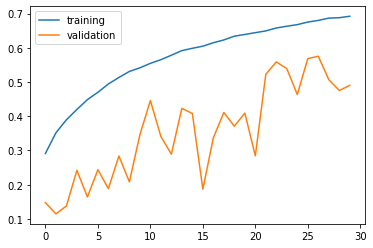

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [26]:
loss,accuracy = densenet_121.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)

10000/1 - 11s - loss: 1.6920 - accuracy: 0.4802
test loss 1.9713692945480348
test accuracy 0.4802


In [ ]:
#Train densenet_169
densenet_169.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])

history = densenet_169.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()


### 4.2 Test your models. (5 marks)

In [ ]:
# implement your code here.
#test densenet_121 

In [ ]:
#test densenet_169 

---
## 5. Load the pre-trained models from Keras and evaluate them. (15 marks)

In [12]:
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# dense121_model = DenseNet121(include_top=False,weights='imagenet',input_shape=(32,32,3))

# dense121_model.summary()

base_model = DenseNet121(include_top=False,weights='imagenet',input_shape=(32,32,3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
predictions = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_20 (ZeroPadding2 (None, 38, 38, 3)    0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_20[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.reshape((50000, 32, 32, 3)).astype('float32') / 255
x_test = x_test.reshape((10000, 32, 32, 3)).astype('float32') / 255

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"  #选择哪一块gpu
config = ConfigProto()
config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
config.gpu_options.per_process_gpu_memory_fraction=0.8  #分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
config.gpu_options.allow_growth = True   #按需分配显存，这个比较重要
session = InteractiveSession(config=config)

# dense121_model = DenseNet121(blocks=[6, 12, 24, 16],include_top=False,weights='imagenet',input_shape=(32,32,3))


# y_train = to_categorical(y_train, 10)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=10,
                    validation_split=0.1)

session.close()
# implement your code here.

E:\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 114s 3ms/sample - loss: 0.9859 - accuracy: 0.6702 - val_loss: 62.3670 - val_accuracy: 0.4938
Epoch 2/10
45000/45000 [==============================] - 94s 2ms/sample - loss: 0.7174 - accuracy: 0.7586 - val_loss: 0.5558 - val_accuracy: 0.8066
Epoch 3/10
45000/45000 [==============================] - 94s 2ms/sample - loss: 0.6961 - accuracy: 0.7675 - val_loss: 2.3136 - val_accuracy: 0.4654
Epoch 4/10
45000/45000 [==============================] - 94s 2ms/sample - loss: 0.6127 - accuracy: 0.7940 - val_loss: 1.0076 - val_accuracy: 0.6984
Epoch 5/10
45000/45000 [==============================] - 94s 2ms/sample - loss: 0.5473 - accuracy: 0.8175 - val_loss: 2.4486 - val_accuracy: 0.7570
Epoch 6/10
45000/45000 [==============================] - 95s 2ms/sample - loss: 0.6189 - accuracy: 0.7964 - val_loss: 0.7305 - val_accuracy: 0.7442
Epoch 7/10
45000/45000 [==============================]

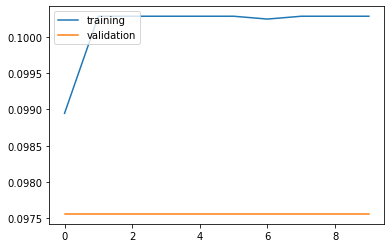

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [14]:
loss,accuracy = dense121_model.evaluate(x_test,y_test,verbose=2)
print('test loss',loss)
print('test accuracy',accuracy)

10000/1 - 9s - loss: 2.3811 - accuracy: 0.1001
test loss 2.4549483810424806
test accuracy 0.100089446


In [ ]:
dense169_model = DenseNet121(include_top=False,weights=None,input_shape=(32,32,3))

dense169_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(),
              metrics=['accuracy'])
dense169_model.fit(x_train, y_train)
history = dense169_model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=5,
                    validation_split=0.1)


---
## 6. Analysis your results. (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Is your implementation of DenseNet-169 better than DenseNet-121? If yes, how is the improvement? If no, try to figure the reason out based on your experiments. (10 marks)

Answer:

2. Compare the results of your implementation with the pre-trained models from Keras. (10 marks)

Answer:

